# Noise and Baseline Removal

In [1]:
# Fix RC overwriting
%config InlineBackend.rc = {}

import awkward as ak
import numpy as np
from matplotlib import pyplot as plt
from mplhep.styles import ROOT
from texat.signal.statistics import rolling_statistics
from texat.utils.awkward.convert import from_hdf5
from texat.utils.awkward.structure import groupby, make_jagged

plt.style.use(ROOT)
plt.rc("figure", figsize=(10, 5), dpi=120)

## Electronic Noise Removal

As discussed in {ref}`content:get-architecture`, the AGET chip provides four additional channels for measuring the electronic noise see {numref}`fpn-averaging`). These channels can be used to eliminate some of the electronic noise inherent within the system. 

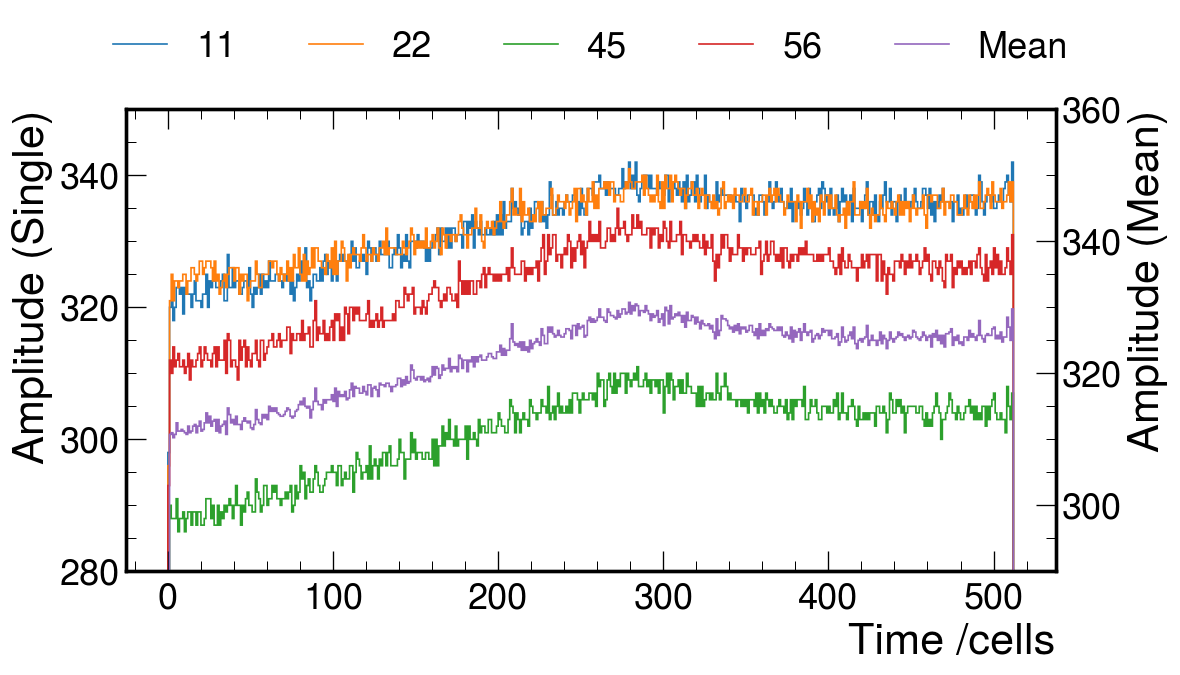

In [42]:
# Load chan and group by AGET
chan_ext = from_hdf5("data/GET-event.h5")
by_aget = groupby(chan_ext.addr.index.aget, chan_ext).slot1

# Split into FPN and measured components
# by grouping each set of event lists according
# to the unique ASAD address.
# Now we have n_event * n_asad * n(asad) * ...
is_fpn = by_aget.addr.is_fpn
get = by_aget[is_fpn]
measured = by_aget[~is_fpn]

# Determine average FPN for each AGET
# Make regular in -2 axis (number of FPN waveforms per AGET=1)
baseline = ak.to_regular(
    ak.mean(get.sample, axis=-2, keepdims=True, mask_identity=False), axis=-2
)

fig_baseline, ax = plt.subplots()
ax.set_ylabel("Amplitude (Single)")
ax2 = ax.twinx()
stairs = [ax.stairs(c.sample, label=c.addr.chan) for c in get[0]]
stairs += [ax2.stairs(baseline[0, 0], color="C4", label="Mean")]
ax.set_ylim(280, 350)
ax2.set_ylim(280 + 10, 350 + 10)
ax2.set_ylabel("Amplitude (Mean)")
ax.set_xlabel("Time /cells")
plt.legend(
    handles=stairs,
    bbox_to_anchor=(0.5, 1.25),
    loc="upper center",
    fancybox=True,
    shadow=True,
    ncol=5,
);

As seen in {numref}`fpn-averaging`, the FPN waveforms typically include a non-linear baseline component. This component, when subtracted from non-FPN channels, restores the constant floor of the measured signals (see {numref}`fpn-baseline-subtraction`). A number of noise removal strategies are discussed in {cite:ps}`giovinazzo_get_2016`, where it is established that an average over the set of FPN channels per-chip is optimal.

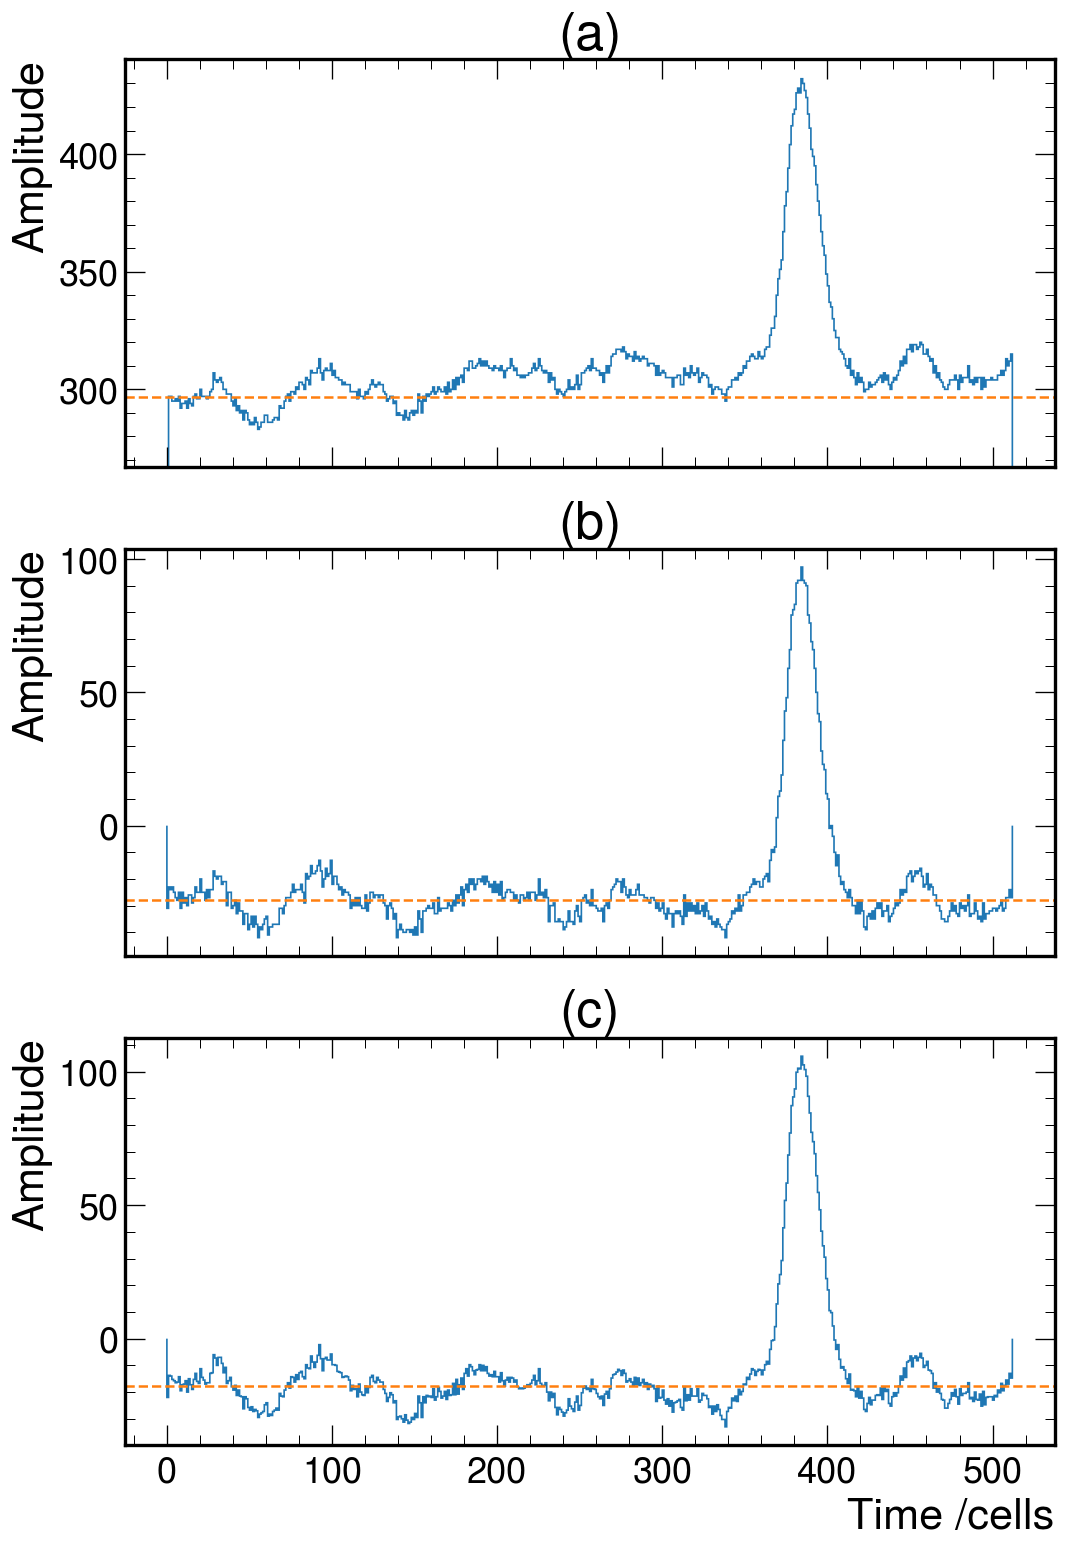

In [12]:
fig_fpn, ax = plt.subplots(3, figsize=(10, 5 * 3), sharex=True)

y = measured[0, 4].sample
y_dy = measured[0, 4].sample - get.sample[0, 0]
y_mean_dy = measured[0, 4].sample - baseline[0, 0]

ax[0].stairs(y, baseline=np.min(y))
ax[0].set_title("(a)")
ax[0].set_ylabel("Amplitude")
ax[1].stairs(y_dy)
ax[1].set_title("(b)")
ax[1].set_ylabel("Amplitude")
ax[2].stairs(y_mean_dy)
ax[2].set_title("(c)")
ax[2].set_ylabel("Amplitude")
ax[0].axhline(np.mean(y[:150]), linestyle="--", color="C1")
ax[1].axhline(np.mean(y_dy[:150]), linestyle="--", color="C1")
ax[2].axhline(np.mean(y_mean_dy[:150]), linestyle="--", color="C1")
ax[2].set_xlabel("Time /cells");

In addition to a low frequency component of the electronic noise, a separate baseline offset was observed in the MicroMeGAS and silicon detector channels. This component was removed using two separate methods:

## MicroMeGaS Baseline Estimation

Given that time in the MicroMeGaS is primarly determined by the drift time of the liberated electrons in the gas volume, the baseline observed in the MicroMeGaS detector was not seen to occur at specific times. Therefore, in order to identify the region of baseline that would be linearly subtracted from the recorded signal, a local variance was computed for the channel samples, with a window of 96 cells. The value of the baseline was given by the locus of the minimum computed variance (see {numref}`baseline-estimate-micromegas`).

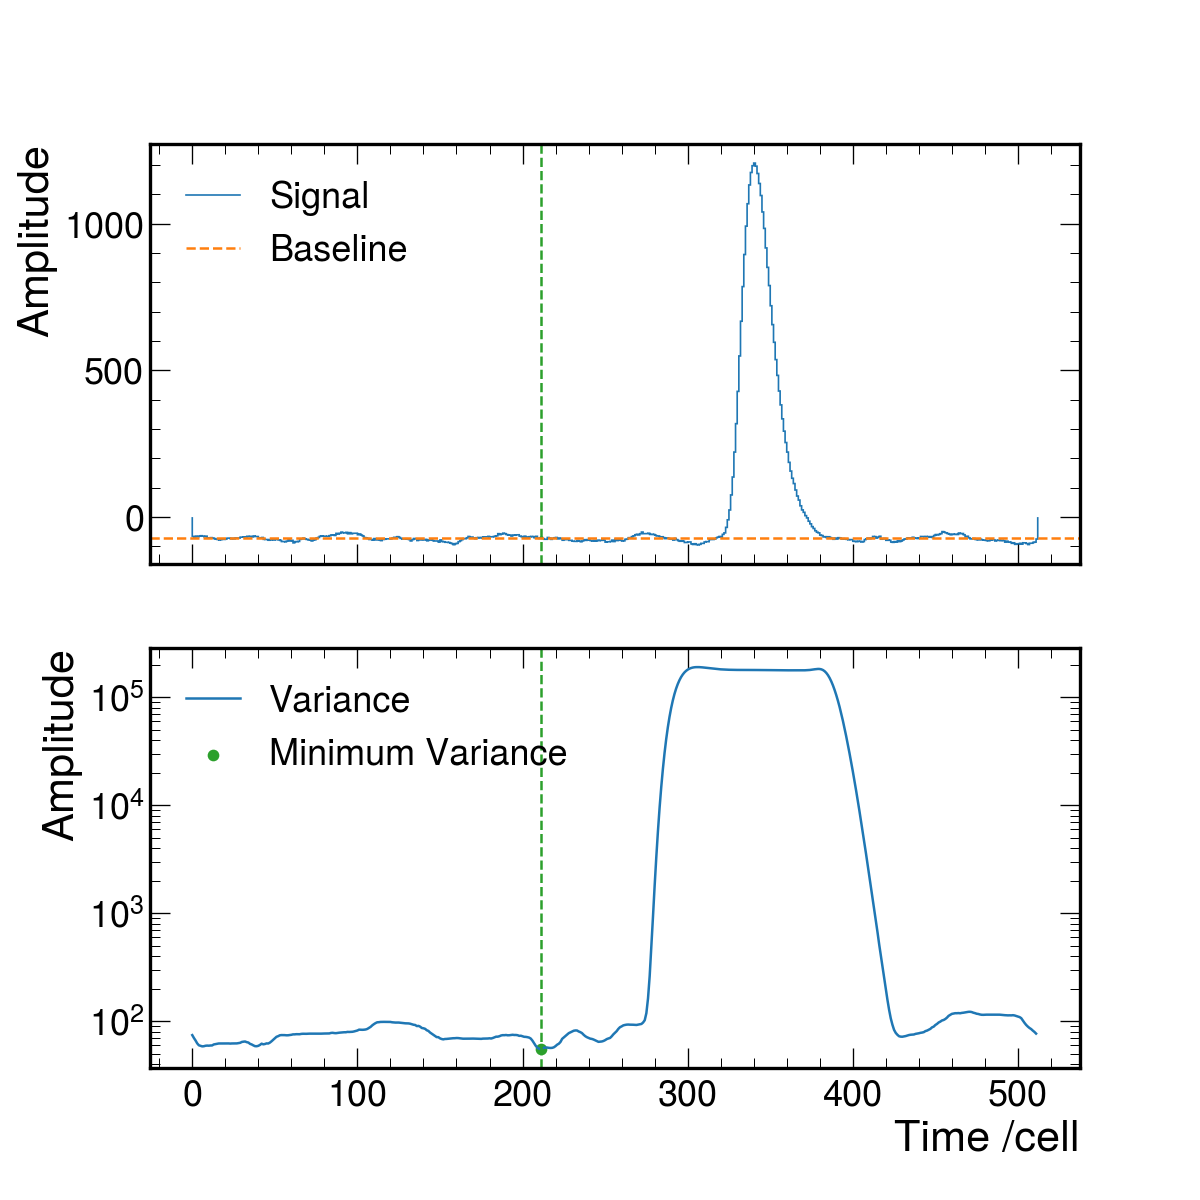

In [13]:
chan = chan_ext.remove_electronic_noise()
sample = ak.values_astype(chan.sample, np.float32)

# Remove baseline
stats = rolling_statistics(sample, 48)
# Find minimum local variance
j_baseline = ak.argmin(stats.var, keepdims=True, axis=-1, mask_identity=False)
# Compute amplitude
stats_baseline = ak.to_regular(stats[make_jagged(j_baseline)])

fig_mm_baseline, ax = plt.subplots(2, 1, figsize=(10, 10), sharex=True)

ax[0].axvline(j_baseline[32], linestyle="--", color="C2")
handles = [
    ax[0].stairs(sample[32], label="Signal"),
    ax[0].axhline(
        stats_baseline.mean[32], linestyle="--", color="C1", label="Baseline"
    ),
]
ax[0].set_ylabel("Amplitude")
ax[0].legend(loc="upper left")
ax[1].semilogy(stats.var[32], label="Variance")
ax[1].scatter(
    j_baseline[32], stats_baseline.var[32], color="C2", label="Minimum Variance"
)
ax[1].axvline(j_baseline[32], linestyle="--", color="C2")
ax[1].set_xlabel("Time /cell")
ax[1].set_ylabel("Amplitude")
ax[1].legend(loc="upper left");

## Silicon Baseline Estimation

Unlike the MicroMeGaS channels, the silicon quadrant detectors have a well defined boundary between the baseline and the interaction signals. This boundary occurs at a similar time for each detector, as it is the silicon detectors upon which the GET system was configured to trigger. To determine the baseline value, the mean of the sample values for the preceeding ten cells was used (see {numref}`baseline-estimate-silicon`).

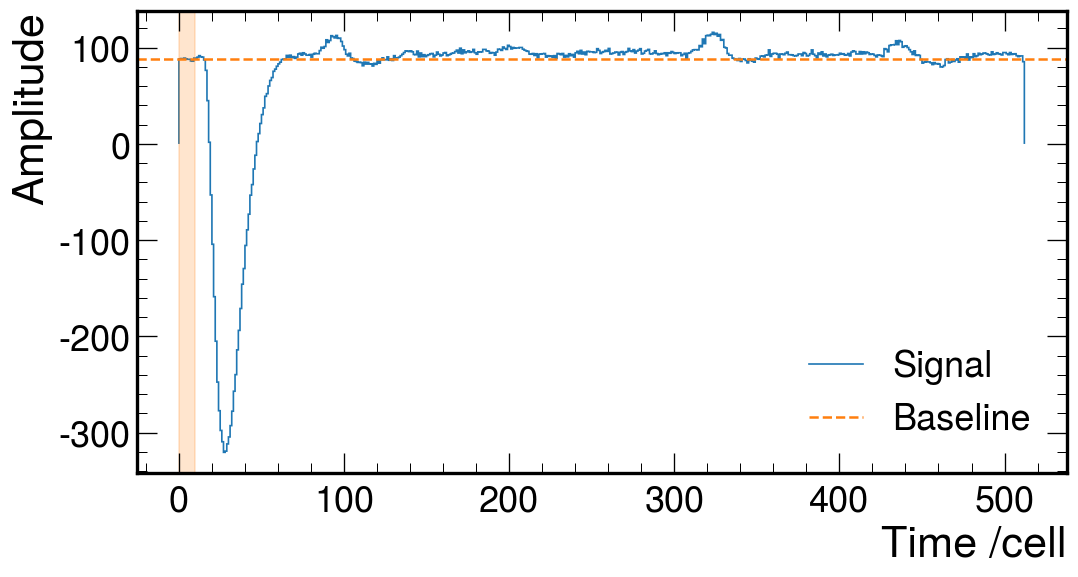

In [43]:
# Remove baseline
y_si_baseline = ak.mean(sample[..., :10], axis=-1, mask_identity=False)

fig_si_baseline, ax = plt.subplots()
ax.stairs(sample[93], label="Signal"),
ax.axhline(y_si_baseline[93], linestyle="--", color="C1", label="Baseline"),
ax.axvspan(0, 10, alpha=0.2, color="C1")
ax.set_xlabel("Time /cell")
ax.set_ylabel("Amplitude")
ax.legend();

In addition to removing the baseline component of the signal, it is also inverted as the polarity is an experimental detail.